# Deep learning in Power System Security Assessment

presented by Dixing (Dex) Xu, Linkang Du, Mingyang Sun

## Training

* **Input**: nomial case 12k
* **Output**: 22 binary labels
* **Model**: Neural Networks (2 fully connected layers)

### Folder structure

<pre>
IEEE 68 bus system/
├── distribution_changes/
│   ├── change_a=1.0b=2.0c=0.0/
|   └── ...
├── nomial case 12k/
│   ├── cont_labels.csv
|   ├── line_P_IEEE68AC.csv
|   ├── line_Q_IEEE68AC.csv
|   ├── P_sol_IEEE68AC.csv
|   ├── Q_sol_IEEE68AC.csv
|   ├── V_sol_IEEE68AC.csv
│   └── zeta_sol_IEEE68AC.csv
├── nomial case 120k/
│   ├── cont_labels.csv
|   ├── line_P_IEEE68AC.csv
|   ├── line_Q_IEEE68AC.csv
|   ├── P_sol_IEEE68AC.csv
|   ├── Q_sol_IEEE68AC.csv
|   ├── V_sol_IEEE68AC.csv
│   └── zeta_sol_IEEE68AC.csv
├── topology changes extended - no labels/
|   ├── 17 36/
│   └── ...
├── topology data/
|   ├── 17 36/
│   └── ...
└── <b>demo.ipynb</b>
</pre>

In [1]:
import torch
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import time
%matplotlib inline
sns.set(style="whitegrid") 

# set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [2]:
def get_input():
    """Get input data from folders."""
    
    y = pd.read_csv('nominal case 12k/cont_labels.csv', header=None)
    x1 = pd.read_csv('nominal case 12k/line_P_IEEE68AC.csv', header=None)
    x2 = pd.read_csv('nominal case 12k/line_Q_IEEE68AC.csv', header=None)
    x3 = pd.read_csv('nominal case 12k/P_sol_IEEE68AC.csv', header=None)
    x4 = pd.read_csv('nominal case 12k/Q_sol_IEEE68AC.csv', header=None)
    x5 = pd.read_csv('nominal case 12k/V_sol_IEEE68AC.csv', header=None)
    x6 = pd.read_csv('nominal case 12k/zeta_sol_IEEE68AC.csv', header=None)
    x = pd.concat([x1, x2, x3, x4, x5, x6], axis=1)
    return x, y

def train(X, y, update_model=False, epoch=1000, save_path='model.pt', test_size=0.1, save_model=True):
    """vanilla neural networks model"""

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    X_train = torch.tensor(X_train.values)
    y_train = torch.tensor(y_train.values)
    X_test = torch.tensor(X_test.values)
    y_test = torch.tensor(y_test.values)
    
    print(f'training shape: {X_train.shape}')
    print(f'testing size: {X_test.shape}')

    model = torch.nn.Sequential(
        torch.nn.Linear(438, 1000),
        torch.nn.ReLU(),
        torch.nn.Linear(1000, 22)
    )
    # model = model.float()

    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    if update_model:
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # epoch = checkpoint['epoch']
#         loss = checkpoint['loss']

    for t in range(epoch):
        now = time.time()
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(X_train.float())
        # y_pred = torch.sigmoid(y_pred).data > 0.5
        # print(type(y_pred))

        # Compute and print loss.
        loss = loss_fn(y_pred, y_train.float())

        y_pred = y_pred > 0.5
        correct = (y_pred.numpy() == y_train.numpy().astype(int)).sum()
        total = len(y_train) * 22
        train_acc = 100 * correct/total

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the Tensors it will update (which are the learnable weights
        # of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()


        y_test_pred = model(X_test.float())
        y_test_pred = y_test_pred > 0.5
        correct = (y_test_pred.numpy() == y_test.numpy().astype(int)).sum()
        total = len(y_test) * 22
        test_acc = 100 * correct/total
        if t % 100 == 0:
            print(f'round {t} loss: {loss.item():5f} train_acc: {train_acc:5f} test_acc: {test_acc:5f}, time: {time.time()-now}')

    if save_model:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                    }, save_path)
    #     torch.save(model, save_path)

    print(classification_report(y_test, y_test_pred))
    
def test(X, y, model_path):

    model = torch.nn.Sequential(
        torch.nn.Linear(438, 1000),
        torch.nn.ReLU(),
        torch.nn.Linear(1000, 22)
    )
    # model = model.float()

    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.eval()

    X = torch.tensor(X.values)
    y = torch.tensor(y.values)

    y_test_pred = model(X.float())
    y_test_pred = y_test_pred > 0.5
    correct = (y_test_pred.numpy() == y.numpy().astype(int)).sum()
    total = len(y) * 22
    acc = 100 * correct/total
    print(f'acc: {acc:5f}')
    print(classification_report(y, y_test_pred))



def train2(X, y):
    """naive mlp classifier"""
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
    print(clf.fit(X_train, y_train))
    predicted = clf.predict(X_test)
    
def train3(X, y):
    """decision tree classifier"""
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    from sklearn.tree import DecisionTreeRegressor

    reg = DecisionTreeRegressor(max_depth=10)
    reg.fit(X_train, y_train)

    predicted = reg.predict(X_test)
    correct = (predicted == y_test.values).sum()
    total = len(y_test) * 22
    test_acc = 100 * correct/total
    print(f'test acc: {test_acc}')

## Supervised Learning

First, we train a vanilla model to get a feeling on how the model might behave. Then, we will use fewer training data to simulate a semi-supervised learning environment.

In [3]:
X, y = get_input()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
train(X_train, y_train, save_path='supervised-learning.h5', test_size=0.1)
test(X_test, y_test, model_path='supervised-learning.h5')

training shape: torch.Size([9720, 438])
testing size: torch.Size([1080, 438])
round 0 loss: 0.920145 train_acc: 51.404789 test_acc: 55.664983, time: 0.7694761753082275
round 100 loss: 0.260439 train_acc: 87.881594 test_acc: 87.975589, time: 0.36970996856689453
round 200 loss: 0.172574 train_acc: 92.665077 test_acc: 92.571549, time: 0.386474609375
round 300 loss: 0.131024 train_acc: 94.496352 test_acc: 94.372896, time: 0.42364978790283203
round 400 loss: 0.107050 train_acc: 95.602319 test_acc: 95.450337, time: 0.42418813705444336
round 500 loss: 0.092048 train_acc: 96.256547 test_acc: 96.098485, time: 0.2802407741546631
round 600 loss: 0.081755 train_acc: 96.701740 test_acc: 96.506734, time: 0.4046931266784668
round 700 loss: 0.074068 train_acc: 97.030958 test_acc: 96.784512, time: 0.39279937744140625
round 800 loss: 0.068169 train_acc: 97.340067 test_acc: 96.969697, time: 0.36612558364868164
round 900 loss: 0.063441 train_acc: 97.513562 test_acc: 97.188552, time: 0.35079240798950195
  

/home/dex/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/dex/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [12]:
test(X_test, y_test, model_path='supervised-learning.h5')

acc: 97.848485
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1101
           1       1.00      0.99      0.99      1098
           2       0.98      0.98      0.98      1049
           3       0.99      0.99      0.99      1151
           4       1.00      1.00      1.00      1185
           5       0.98      0.89      0.93       380
           6       0.99      0.94      0.96       377
           7       0.99      0.99      0.99      1129
           8       0.99      0.99      0.99      1123
           9       1.00      0.94      0.97       109
          10       1.00      0.96      0.98       113
          11       0.99      0.99      0.99      1086
          12       0.99      0.96      0.97       639
          13       0.98      0.93      0.95       619
          14       0.97      0.95      0.96       308
          15       0.97      0.92      0.94       335
          16       0.95      0.88      0.92       172
          17

## Semi-Supervised Learning (SSL)

Now, we use very few training samples without changing the neural network (NN) model to see how it might behave.

In [14]:
train(X_train, y_train, save_path='ssl.h5', test_size=0.99)
test(X_test, y_test, model_path='ssl.h5')

training shape: torch.Size([108, 438])
testing size: torch.Size([10692, 438])
round 0 loss: 0.917792 train_acc: 47.685185 test_acc: 54.230861, time: 0.21869540214538574
round 100 loss: 0.251627 train_acc: 88.341751 test_acc: 87.885165, time: 0.22249341011047363
round 200 loss: 0.152057 train_acc: 94.023569 test_acc: 91.341020, time: 0.2336289882659912
round 300 loss: 0.104642 train_acc: 95.959596 test_acc: 92.434445, time: 0.2205953598022461
round 400 loss: 0.076912 train_acc: 97.432660 test_acc: 92.996888, time: 0.21139073371887207
round 500 loss: 0.058571 train_acc: 98.569024 test_acc: 93.327637, time: 0.23144030570983887
round 600 loss: 0.045645 train_acc: 99.074074 test_acc: 93.489610, time: 0.23174214363098145
round 700 loss: 0.036120 train_acc: 99.326599 test_acc: 93.577611, time: 0.25435471534729004
round 800 loss: 0.028835 train_acc: 99.494949 test_acc: 93.660511, time: 0.24634718894958496
round 900 loss: 0.023206 train_acc: 99.705387 test_acc: 93.692395, time: 0.23712229728698

## Analysis of SSL result (1)

From classification report, we can see that for class 16, the recall is particularly low (0.6 compared to 0.93 avarage), so we want to target this class and improve the performance.

In [ ]:
# now we train another 1000 epochs with more data

train(X_train, y_train, save_path='ssl2.h5', test_size=0.9, save_model=True, update_model=True)
test(X_test, y_test, model_path='ssl2.h5')

## Analysis of SSL result (2)

The result looks great but the question remains - can we do better with less data and we test with 95% of test data again.

In [ ]:
train(X_train, y_train, save_path='ssl3.h5', test_size=0.95, save_model=True, update_model=True)
test(X_test, y_test, model_path='ssl3.h5')

In [ ]:
train(X_train, y_train, save_path='ssl1.h5', test_size=0.97, save_model=True, update_model=True)
test(X_test, y_test, model_path='ssl1.h5')

## Test with unseen data

data from `topology changes`

In [3]:
def test(model_path, x, y):
    # print(x.shape)
    # print(y.shape)
    #model = torch.load('nominal case 12k/model.h5')
    model = torch.load(model_path)
#     model = torch.nn.Sequential(
#         torch.nn.Linear(438, 1000),
#         torch.nn.ReLU(),
#         torch.nn.Linear(1000, 22)
#     )    
#     model.load_state_dict(torch.load('5150.pt')['model_state_dict'])
    model.eval()
    x = torch.tensor(x.values.astype(np.float32))
    y = torch.tensor(y.values.astype(np.float32))
    y_pred = model(x)
    y_pred = y_pred > 0.5
    correct = (y_pred.numpy() == y.numpy().astype(int)).sum()
    total = len(y) * 22
    test_acc = 100 * correct/total
#     print(f'folder: {fname} test_acc: {test_acc:5f}')
#     print(classification_report(y.numpy(), y_pred.numpy()))
#     print(type(y_pred))
#     print(type(y))
    precision, recall, fscore, _ = precision_recall_fscore_support(y.numpy(), y_pred.numpy(), average='micro')
#     data2 = classification_report(y.numpy(), y_pred.numpy())
#     print(f'length of function prfs: {len(data)}')
#     print(data)
#     print(f'type of classification report {type(data2)}, length of classification report {len(data2)}')
#     print(data2)
#     labels = ['precision', 'recall', 'fscore', 'support']
#     for i in range(len(data)):
#         print(type(data[i]))
#         ax = sns.boxplot(data=data[i])
#         ax.set(xlabel=labels[i])
#         plt.show()
    return precision, recall, fscore

In [4]:
def get_test():

    i = 0

    p = []
    r = []
    f = []
    d = []
        
    rootdir = 'topology_data'
    for subdir, dirs, files in os.walk(rootdir):
        x = {}
        for file in files:

            if file == 'cont_labels.csv':
                y = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'line_P_IEEE68AC.csv':
                x[0] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'line_Q_IEEE68AC.csv':
                x[1] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'P_sol_IEEE68AC.csv':
                x[2] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'Q_sol_IEEE68AC.csv' :
                x[3] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'V_sol_IEEE68AC.csv' :
                x[4] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'zeta_sol_IEEE68AC.csv' :
                x[5] = pd.read_csv(os.path.join(subdir, file), header=None)
            else:
                print("ERROR: the following file is not handled")
                print(os.path.join(subdir, file))

    
        if subdir != 'topology_data' and not subdir is None:
            x = pd.concat(x, axis=1)

            precision, recall, fscore = test('models/2753', x, y)
            s = 'models/' + subdir.split('/')[1].replace(" ", "")
#             if subdir == 'topology_data/19 68':
#                 train(x, y, update_model=False, save_path=s, epoch=3000, test_size=0.9)
            p.append(precision)
            r.append(recall)
            f.append(fscore)
            d.append(subdir)
    
    return p, r, f, d

In [5]:
# get_test()
p, r, f, d = get_test()
# precision, recall, fscore = test('models/1968', x, y)
# print(precision)
# print(recall)
# print(fscore)

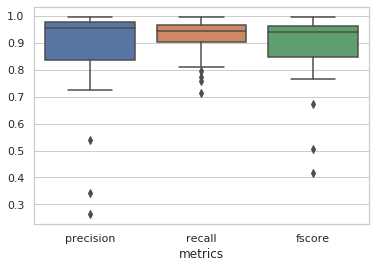

In [6]:
ax = sns.boxplot(data=[p, r, f])
ax.set(xlabel='metrics')
ax.set_xticklabels(['precision','recall','fscore'])
plt.show()

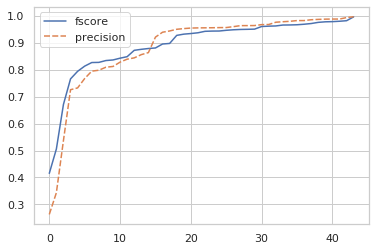

In [7]:
sorted_f = sorted(f)
sorted_p = sorted(p)
ax = sns.lineplot(data=[np.array(sorted_f), np.array(sorted_p)])
ax.legend(['fscore', 'precision'])
plt.show()
# print(sorted_f)
# print(sorted_p)

In [8]:
npp = np.array(p)
idx = np.argsort(npp)[:3]
print(np.array(d)[idx.astype(int)])
npp = np.array(f)
idx = np.argsort(npp)[:3]
print(np.array(d)[idx.astype(int)])

['topology_data/19 68' 'topology_data/51 50' 'topology_data/42 18']
['topology_data/19 68' 'topology_data/51 50' 'topology_data/42 18']


In [9]:
# smaller false positive the better
print(sorted_f)
print()
print(sorted_p)

[0.41517154548316015, 0.5056347589952478, 0.671332230563685, 0.7661958110082805, 0.7943389868583625, 0.8136416429099357, 0.8270116979794399, 0.8275630252100841, 0.8344021988089785, 0.8365718960932707, 0.8431461695839965, 0.848820142260359, 0.8723732407942933, 0.8761088408252766, 0.8790935126385256, 0.8811290911303079, 0.8958309406224877, 0.8979164684616117, 0.9278811921472891, 0.9324915824915825, 0.9347368421052632, 0.9375738945377157, 0.943009430094301, 0.9438775510204082, 0.944094638427781, 0.9467929317582738, 0.9487207168304005, 0.9499334493703286, 0.9504769636695758, 0.9511050264032858, 0.9608870967741936, 0.9621556161065699, 0.962962962962963, 0.9663493966874017, 0.9666425694516162, 0.9673948133003337, 0.9693251533742332, 0.9719549641760492, 0.9762906702247767, 0.9783426537874936, 0.9790068631408962, 0.9804039794995478, 0.9824526018555869, 0.9967611336032389]

[0.26259207644833765, 0.3432258064516129, 0.5373803218578121, 0.7260558504500346, 0.7326978864484045, 0.7676128241780682, 

In [10]:
checkpoint = torch.load('model.pt')
print(checkpoint)

{'epoch': 1000, 'model_state_dict': OrderedDict([('0.weight', tensor([[-0.0489, -0.0401, -0.0181,  ..., -0.0308,  0.0213,  0.0184],
        [ 0.0561, -0.0209,  0.0063,  ...,  0.0202, -0.0352, -0.0018],
        [ 0.0119,  0.0076,  0.0361,  ..., -0.0373,  0.0068,  0.0114],
        ...,
        [ 0.0240, -0.0481,  0.0464,  ..., -0.0327,  0.0431, -0.0098],
        [-0.0399,  0.0021, -0.0327,  ..., -0.0259, -0.0059,  0.0255],
        [-0.0273, -0.0321,  0.0383,  ...,  0.0507,  0.0147,  0.0341]])), ('0.bias', tensor([-2.9034e-02,  1.1689e-03,  4.9972e-02,  3.5833e-02, -3.1223e-02,
        -3.4738e-02, -2.4668e-02, -1.5004e-04, -4.2279e-03,  1.6847e-02,
        -2.3583e-02,  4.2623e-02, -2.9992e-03, -3.4270e-02, -1.5129e-02,
        -1.5627e-02, -1.0323e-02,  1.7174e-02, -2.7022e-02, -3.3152e-02,
        -1.3818e-03, -4.1087e-02,  3.5267e-02, -6.1132e-02,  5.0383e-03,
         3.8483e-02, -3.9817e-02, -1.3085e-02, -2.9348e-02, -1.5151e-02,
         5.0339e-02,  2.9219e-02,  1.1793e-02, -4.972

In [11]:
def get_test_data():

    i = 0
    y = {}
    x = {}
    for i in range(6):
        x[i] = {}
    p = []
    r = []
    f = []
    d = []
        
    rootdir = 'topology_data'
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file == 'cont_labels.csv':
                y[i] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'line_P_IEEE68AC.csv':
                x[0][i] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'line_Q_IEEE68AC.csv':
                x[1][i] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'P_sol_IEEE68AC.csv':
                x[2][i] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'Q_sol_IEEE68AC.csv' :
                x[3][i] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'V_sol_IEEE68AC.csv' :
                x[4][i] = pd.read_csv(os.path.join(subdir, file), header=None)
            elif file == 'zeta_sol_IEEE68AC.csv' :
                x[5][i] = pd.read_csv(os.path.join(subdir, file), header=None)
            else:
                print("ERROR: the following file is not handled")
                print(os.path.join(subdir, file))
            i+=1
            
    for j in range(6):
        x[j] = pd.concat(x[j], ignore_index=True)


    y = pd.concat(y)
    x = pd.concat(x, axis=1)

    return x, y

In [12]:
x, y = get_test_data()

In [13]:
from glob import glob

x, y = get_test_data()

ptest = []
rtest = []
ftest = []
m = []

for model_path in glob('models/*'):
    precision, recall, fscore = test(model_path, x, y)
    ptest.append(precision)
    rtest.append(recall)
    ftest.append(fscore)
    m.append(model_path)

In [14]:
print(ptest)

[0.6568327778763796, 0.8331837491772871, 0.8471009713007153, 0.9099646813777281, 0.8881053751995742, 0.8792048929663608, 0.8741495361106058, 0.8834919114738398, 0.8905420044273028, 0.882987755935286, 0.8443796464129035, 0.8760011428027237, 0.851507831649562, 0.8601597388425811, 0.836074471075101, 0.8839121205358301, 0.8796961299930253, 0.8531570358215146, 0.8390924274961498, 0.850583175107529, 0.9014849838194228, 0.881879998885266, 0.8849959253609713, 0.8793278505432024, 0.8852689941709629, 0.844871731188671, 0.8461974483967455, 0.8514641531812424, 0.817518450056929, 0.9271106169619089, 0.8448482956294745, 0.8403850113238625, 0.8688867539976836, 0.8814622180416459, 0.8799571176825144, 0.8832708764472286, 0.8714288322167254, 0.8786837797442528, 0.8864749543168245, 0.8907756449231303, 0.8801815556393536, 0.8751272620543535, 0.8634812888438312, 0.8740943354800936]


In [15]:
print(ptest+ftest)

[0.6568327778763796, 0.8331837491772871, 0.8471009713007153, 0.9099646813777281, 0.8881053751995742, 0.8792048929663608, 0.8741495361106058, 0.8834919114738398, 0.8905420044273028, 0.882987755935286, 0.8443796464129035, 0.8760011428027237, 0.851507831649562, 0.8601597388425811, 0.836074471075101, 0.8839121205358301, 0.8796961299930253, 0.8531570358215146, 0.8390924274961498, 0.850583175107529, 0.9014849838194228, 0.881879998885266, 0.8849959253609713, 0.8793278505432024, 0.8852689941709629, 0.844871731188671, 0.8461974483967455, 0.8514641531812424, 0.817518450056929, 0.9271106169619089, 0.8448482956294745, 0.8403850113238625, 0.8688867539976836, 0.8814622180416459, 0.8799571176825144, 0.8832708764472286, 0.8714288322167254, 0.8786837797442528, 0.8864749543168245, 0.8907756449231303, 0.8801815556393536, 0.8751272620543535, 0.8634812888438312, 0.8740943354800936, 0.781568737876228, 0.8530726401779424, 0.46050545425143347, 0.8086529872066914, 0.8080135576806682, 0.8091879974356168, 0.8418

In [16]:
nparr_p = np.array(ptest)
nparr_f = np.array(ftest)
new_arr = nparr_p + nparr_f
idx = np.argsort(new_arr)
print(new_arr[idx])
print(idx)
print(m[9])
print(new_arr[9])
print(m[38])

[1.30760643 1.43840152 1.48530445 1.50355055 1.50394889 1.6539271
 1.67057991 1.68625639 1.68839289 1.69611893 1.71604245 1.71795468
 1.71861767 1.72298638 1.72998372 1.73039441 1.7335373  1.73376066
 1.73500274 1.73510858 1.73544883 1.73551903 1.73584466 1.73782069
 1.74250493 1.7451895  1.75803342 1.76497285 1.76622041 1.76734535
 1.76933617 1.77000314 1.77176956 1.77272176 1.77838085 1.77844917
 1.78079486 1.7810613  1.78174824 1.78175766 1.78206287 1.78316829
 1.78351322 1.7839265 ]
[ 2  0 20 19 29 28 14  1  5  4  6 25  3 18 10 31 27  7 30 22 26 17 15 12
 13  8 11 37 42 36 32 16 43 41 24 23 21 34 40 39 35 33  9 38]
models/2753
1.7835132237341176
models/6364


In [17]:
precision, recall, fscore = test('models/1968', x, y)
print(precision)
print(recall)
print(fscore)
print(x.shape)
print(y.shape)

0.8471009713007153
0.3161998281339011
0.46050545425143347
(17600, 438)
(17600, 22)


# Thank you!